# Stationary Time Series

In [1]:
import pandas as pd
from numpy import log
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.tsa.stattools as st

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import seaborn as sns

import random
from random import gauss
from random import seed

In [2]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [3]:
def compare_mean_variance(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

In [4]:
def adf(series):
    adf_result = st.adfuller(series, store = True)
    print("ADF Test Results: ")
    print("Test Statistic: %.4f" % adf_result[0])
    print("p-value: %.10f" % adf_result[1])
    print("Critical Values: ")
    for key, value in adf_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [5]:
def kpss(series):
    kpss_result = st.kpss(series, store=True)
    print("KPSS Test Results: ")
    print("Test Statistic: %.4f" % kpss_result[0])
    print("p-value: %.10f" % kpss_result[1])
    print("Critical Values: ")
    for key, value in kpss_result[2].items():
        print('\t%s: %0.3f' % (key, value))

=============================================================================================================

# Notion of Stationarity

* It is very difficult to forecast non-deterministic time series as they involve randomness.
This motivates the notion of stationarity. 

* A time series $\{X_t\}_t$ is said to be $\textit{strictly stationary}$ if the 

$$ \text{joint distributions} \quad F(X_{t_1}, \dots, X_{t_n}) \quad \text{and} \quad F( X_{t_1+m}, \dots, X_{t_n +m}) \quad\text{are the same for all} \quad t_1, ... t_n \text{ and } m. $$

* This is a very strong condition, too strong to be applied in practice; it implies that the distribution is unchanged for any time shift!

* A weaker and more practical stationarity condition is that of $\textit{weakly stationary}$ (or $\textit{second order stationarity}$). A time series $\{X_t\}_t$ is said to be $\textit{weakly stationary}$ if it is mean and variance stationary and its autocovariance $Cov(X_t, X_{t+k})$ depends only the time displacement $k.$ Mathematically speaking, 

\begin{align*}
E(X_t) & = \mu \quad \text{for all }t \quad \text{and} \\
Cov(X_t, X_{t+k}) & = \gamma(k) \quad \text{for all }t,h .
\end{align*}

* Second order stationarity plays an important role in many of the time series models; if a time series is second order stationary, then once a distribution assumption such as normality is imposed, the time series can be completely characterized by its mean and covariance structure.

In [6]:
births_csv = pd.read_csv('daily-total-female-births.csv', 
                         index_col = 0)  
births_csv.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [7]:
#import pandas_profiling
#births_csv.profile_report()

# pandas_profiling is a more comprehensive exploratory data analysis function
# it is useful to handle data set with many features
# however, please be aware that it takes much longer time to perform all computations

In [8]:
births_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
Births    365 non-null int64
dtypes: int64(1)
memory usage: 5.7+ KB


In [9]:
births_csv.describe()

,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x11c19da20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x109025860>)

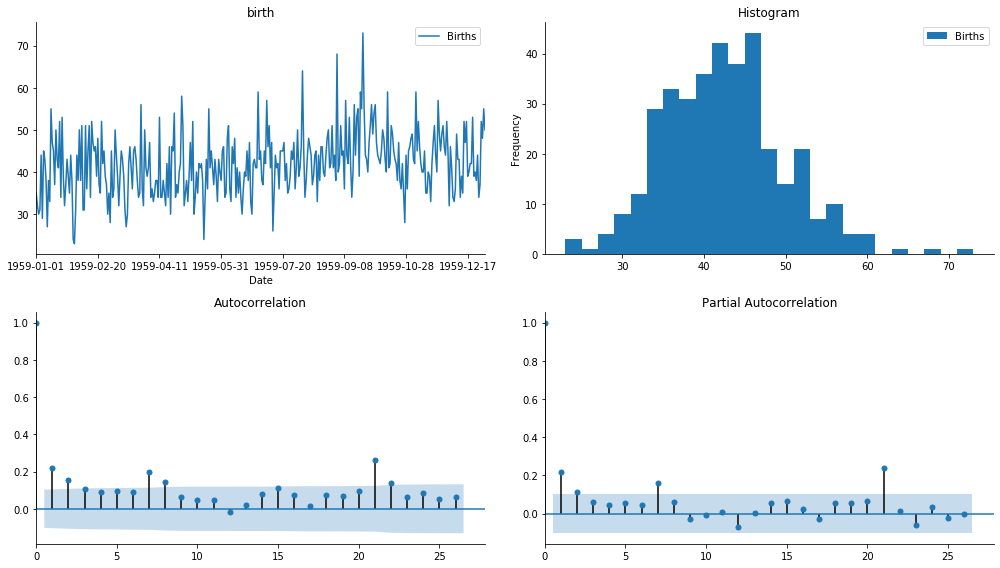

In [10]:
tsplot(births_csv, title = 'birth')

* Is the time series above stationary?

## Non-Stationary Time Series

* Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

* Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

* Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

In [11]:
airline_csv = pd.read_csv('international-airline-passengers.csv',  
                          index_col = 0)

airline_csv.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [12]:
airline_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2+ KB


In [13]:
airline_csv.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


(<matplotlib.axes._subplots.AxesSubplot at 0x11e6000f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e8ea828>)

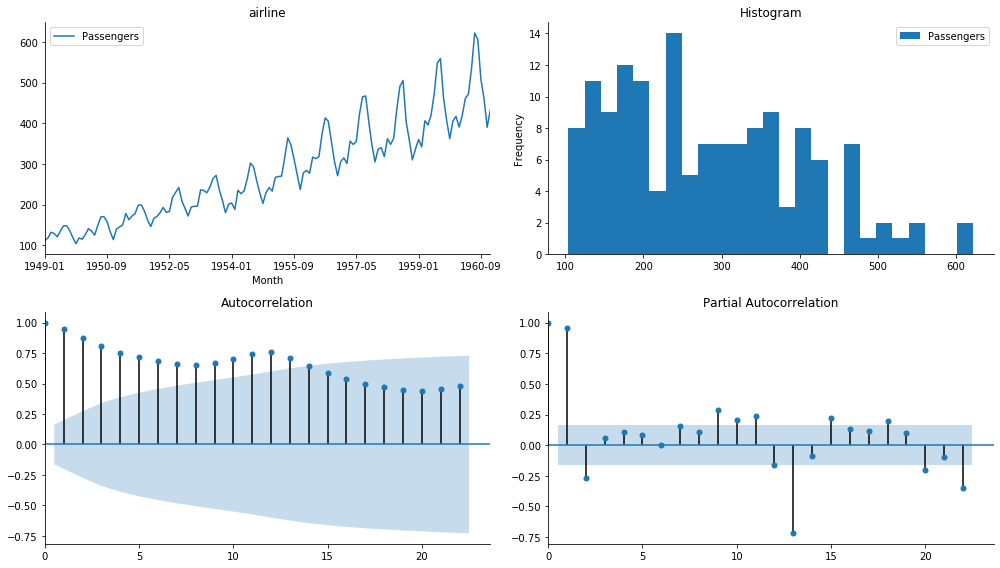

In [14]:
tsplot(airline_csv, title='airline')

## Checks for Stationarity

1. **Look at Plots**: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.

2. **Summary Statistics**: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.

3. **Statistical Tests**: You can use statistical tests to check if the expectations of stationarity are met or have been violated.


* Above, we have already introduced the Daily Female Births and Airline Passengers datasets as stationary and non-stationary respectively with plots showing an obvious lack and presence of trend and seasonality components.

* We will look at a quick and dirty way to calculate and review summary statistics on our time series dataset for checking to see if it is stationary.

### Summary Statistics

* A quick and dirty check to see if your time series is non-stationary is to review summary statistics.

* Split your time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary.

### Examples

#### Daily Births Dataset

Because we are looking at the mean and variance, we are assuming that the data conforms to a Gaussian (also called the bell curve or normal) distribution.

We can also quickly check this by eyeballing a histogram of our observations.

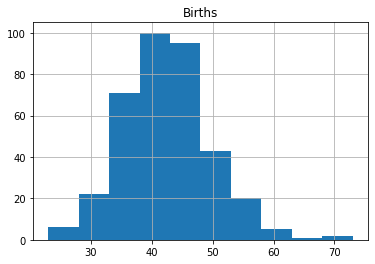

In [15]:
births_csv.hist()
plt.show()

* Clearly the bell curve-like shape of the Gaussian distribution, perhaps with a longer right tail.

* Next, we split the time series into two contiguous sequences to calculate the mean and variance of each group of numbers and compare the values.

In [16]:
compare_mean_variance(births_csv.values)

mean1=39.763736, mean2=44.185792
variance1=49.213410, variance2=48.708651


* Mean and variance values are different, but in the same ball-park.

#### Airline Passengers Dataset

In [17]:
compare_mean_variance(airline_csv.values)

mean1=182.902778, mean2=377.694444
variance1=2244.087770, variance2=7367.962191


* Mean and variance look very different, thus non-stationary.

**Well, maybe.**

* Let’s take one step back and check if assuming a Gaussian distribution makes sense in this case by plotting the values of the time series as a histogram.

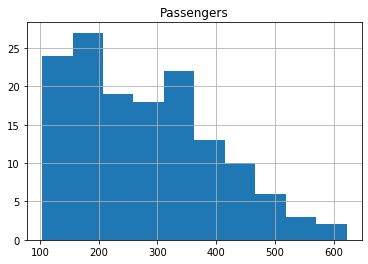

In [18]:
airline_csv.hist()
plt.show()

* The distribution of values does not look like a Gaussian, therefore the mean and variance values are less meaningful.

* The squashed distribution of the observations may be another indicator of a non-stationary time series.

* There is an obvious seasonality component, and it looks like the seasonality component is growing.

* This suggests an exponential growth from season to season. A log transform can be used to flatten out exponential change back to a linear relationship.

* Below is the same histogram with a log transform of the time series.

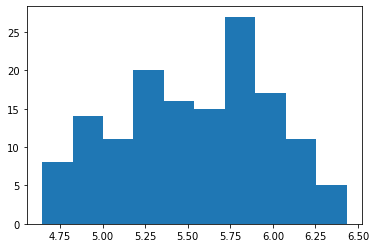

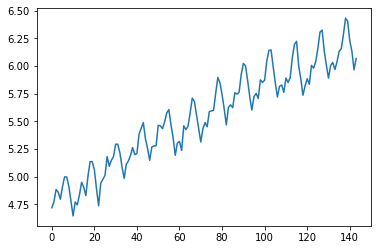

In [19]:
X = log(airline_csv.values)

plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

* More familiar Gaussian-like or Uniform-like distribution of values.

* We also create a line plot of the log transformed data and can see the exponential growth seems diminished, but we still have a trend and seasonal elements.

* We can now calculate the mean and standard deviation of the values of the log transformed dataset.

In [20]:
compare_mean_variance(log(airline_csv.values))

mean1=5.175146, mean2=5.909206
variance1=0.068375, variance2=0.049264


* Mean and standard deviation values for each group that are again similar, but not identical.

* Perhaps, from these numbers alone, we would say the time series is stationary, but we strongly believe this to not be the case from reviewing the line plot.

* This is a quick and dirty method that may be easily fooled.

* We can use a statistical test to check if the difference between two samples of Gaussian random variables is real or a statistical fluke. We could explore statistical significance tests, like the Student t-test, but things get tricky because of the serial correlation between values.

* In the next section, we will use a statistical test designed to explicitly comment on whether a univariate time series is stationary.

## Stationarity Tests

### Augmented Dickey-Fuller test (ADF)

* The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

* The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

* There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

* $H_0:$ There is a unit root (not stationary)     
$H_1:$ There is no unit root (stationary)

* The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

| p-value |  Null Hypothesis      |       Conclusion   |
|---|-----------------------|:--------------------:|
| $\leq 0.05$  | reject                |    stationary    |
| $>0.05$   | fail to reject        |      non-stationary    |




* We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* Recall that the **p-value** is the probability that, when the null hypothesis is true, the statistical summary would be greater than or equal to the actual observed results.

* Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [21]:
adf(births_csv['Births'])

ADF Test Results: 
Test Statistic: -4.8083
p-value: 0.0000524341
Critical Values: 
	1%: -3.449
	5%: -2.870
	10%: -2.571


* The more negative the test statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

* As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.449 at 1%.

* This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

* Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

* We can perform the same test on the Airline Passenger dataset.

In [22]:
adf(airline_csv['Passengers'])

ADF Test Results: 
Test Statistic: 0.8154
p-value: 0.9918802434
Critical Values: 
	1%: -3.482
	5%: -2.884
	10%: -2.579


* The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

* Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

* Let’s log transform the dataset again to make the distribution of values more linear and better meet the expectations of this statistical test.

In [23]:
adf(log(airline_csv['Passengers']))

ADF Test Results: 
Test Statistic: -1.7170
p-value: 0.4223667748
Critical Values: 
	1%: -3.482
	5%: -2.884
	10%: -2.579


* Negative value for the test statistic.

* We can see that the value is larger than the critical values, again, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

===============================================================================================

# Stationarity Tests on White Noise

## ADF test on White Noise

* In this section, we apply ADF test on white noise to determine its stationarity. 

In [24]:
numbers = pd.Series([random.randint(1,100) for i in range(1000)])

(<matplotlib.axes._subplots.AxesSubplot at 0x11f079668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e335e48>)

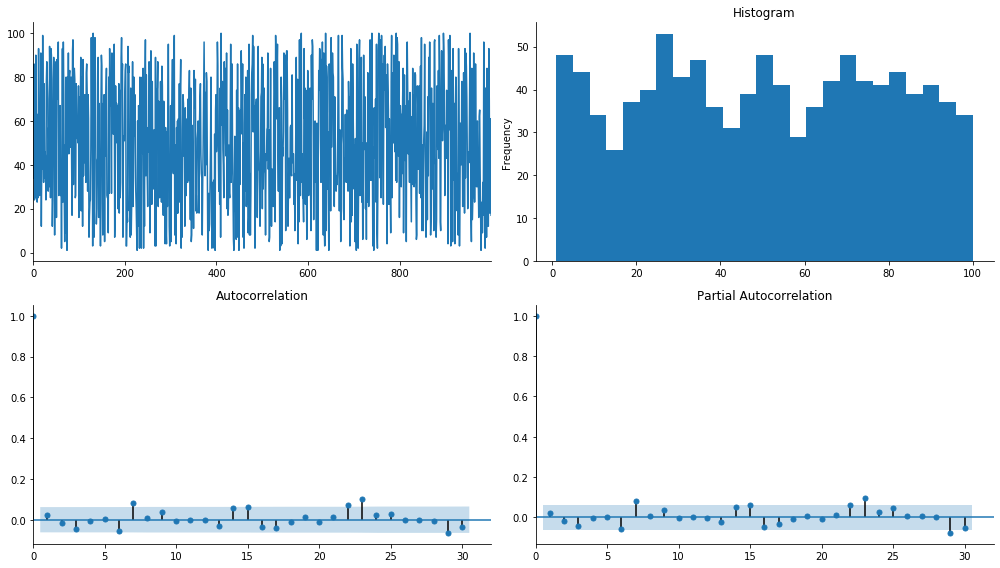

In [25]:
tsplot(numbers)

In [26]:
adf(numbers)

ADF Test Results: 
Test Statistic: -11.6777
p-value: 0.0000000000
Critical Values: 
	1%: -3.437
	5%: -2.864
	10%: -2.568


* Test statistics is very negative and $p$-value is close to zero.

* Statistically speaking, we can reject null hypothesis and conclude that the time series above is stationary with high confidence.

====================================================================================================================

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests

* $H_0$: trend stationary around a deterministic trend
* $H_1$: presence of unit root 

In [27]:
kpss(births_csv['Births'])

KPSS Test Results: 
Test Statistic: 1.1170
p-value: 0.0100000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [28]:
kpss(airline_csv['Passengers'])

KPSS Test Results: 
Test Statistic: 1.0522
p-value: 0.0100000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [29]:
kpss(numbers)

KPSS Test Results: 
Test Statistic: 0.1983
p-value: 0.1000000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
